In [21]:
import json
import os
from os.path import dirname
from pathlib import Path
import numpy as np
import pandas as pd
import math
from pandas.io.json import json_normalize
import psycopg2 as pg
from psycopg2.extras import RealDictCursor
from shutil import copyfile
from tqdm import tqdm
import numpy as np

from dotenv import load_dotenv
load_dotenv('prod.env') # load in db credentials from .env. Ask teammate for this file and place in same dir
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

In [22]:
def sample_sphere(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /=np.linalg.norm(vec, axis=0)
    #vec = vec.flatten()
    return vec

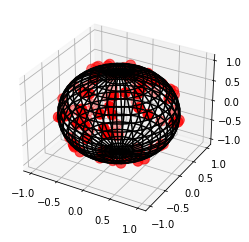

In [23]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_sphere(100, 3)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)

In [24]:
sorted(sample_sphere(10,4), key=lambda x: x[1])

[array([-0.01419658, -0.5480454 ,  0.05477872, -0.27947117,  0.50917201,
        -0.11967016, -0.40668568, -0.29633204,  0.42047576, -0.64224756]),
 array([-0.9609794 , -0.34216009,  0.54001754,  0.25190569, -0.01091405,
         0.09547693,  0.62944856, -0.54545513,  0.55709292, -0.23035672]),
 array([ 0.1124387 ,  0.36352352, -0.59127164,  0.8635484 , -0.52530563,
        -0.9880643 ,  0.57054962,  0.72994822,  0.63552256,  0.71586978]),
 array([-0.25233825,  0.67113587,  0.59647145,  0.33574327,  0.68167348,
         0.01709219,  0.33596784, -0.28607975,  0.33008891, -0.1482711 ])]

In [25]:
def euler_to_quaternion(r):
    (yaw, pitch, roll) = (np.radians(r[0]), np.radians(r[1]), np.radians(r[2]))
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    q= [qw, qx, qy, qz]
    return np.array(q)

In [26]:
def quaternion_to_euler(q):
    (w, x, y, z) = (q[0], q[1], q[2], q[3])
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(t3, t4)
    return np.array([np.degrees(yaw), np.degrees(pitch), np.degrees(roll)])

In [27]:
qs = sample_sphere(10,4).T


In [28]:
q = [ 0.48416448,  0.50199875,  0.6958132 , -0.17154008]

In [29]:
e = quaternion_to_euler(q)
euler_to_quaternion(e)

array([ 0.48416448,  0.50199875,  0.6958132 , -0.17154008])

In [30]:
f= e + [-360, 360, -360]

euler_to_quaternion(f)

array([-0.48416448, -0.50199875, -0.6958132 ,  0.17154008])

In [32]:
#q = w,x,y,z
#if w<0,x<0, and y>0,z>0, than this function returns the negative
[sum(np.isclose(q, euler_to_quaternion(quaternion_to_euler(q))))/4 for q in qs]

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [33]:
#yaw pitch roll
n = 100
pitchesquat = [euler_to_quaternion([0,180*(i+1)/200, 0]) for i in range(n)]

In [70]:
q

array([0.82176438, 0.15142549, 0.42320311, 0.35024672])

In [35]:
#given a list of qs, generate yawpitchroll reading from relative start

yprfromq = [quaternion_to_euler(x) for x in pitch_from_q]
deltaypr = [(x) - (quaternion_to_euler(q)) for x in yprfromq]

In [36]:
replicatecheck = [euler_to_quaternion(quaternion_to_euler(q) + x) for x in deltaypr]

In [38]:
sum([sum(np.isclose(replicatecheck[i], pitch_from_q[i]))/4 for i in range(n)])/n

0.45

In [78]:
q = [ 0.48416448,  0.50199875,  0.6958132 , -0.17154008]
ypr_r = [np.array(quaternion_to_euler(q)) + np.array([0,180*(i+1)/20,180*(i+1)/45]) for i in range(n)]
pitch_from_q =[euler_to_quaternion(x) for x in ypr_r]
times = [100000000 + i*100 for i in range(n)]
w = [a[0] for a in pitch_from_q]
x = [a[1] for a in pitch_from_q]
y = [a[2] for a in pitch_from_q]
z = [a[3] for a in pitch_from_q]

quattimes = pd.DataFrame(data=times,columns=['time'])
quattimes = quattimes.set_index('time')
quattimes['w']=w
quattimes['x']=x
quattimes['y']=y
quattimes['z']=z
quattimes

,w,x,y,z
time,,,,
100000000,0.508303,0.481232,0.670077,-0.247062
100000100,0.531402,0.459732,0.635866,-0.319269
100000200,0.553397,0.437532,0.593612,-0.387224
100000300,0.574226,0.414661,0.543853,-0.450050
100000400,0.593832,0.391150,0.487222,-0.506932
...,...,...,...,...
100009500,-0.707345,0.152704,0.115372,0.680466
100009600,-0.699468,0.180637,0.194439,0.663557
100009700,-0.690070,0.208280,0.271059,0.637927


In [79]:
def smooth_angles(ar):
    #when calculating euler angles from quaternions, we see that measurements sometimes roll over to -180 instead of going from 180-360.
    #smooth_angles will take an array of angles, and when the rollover occurs, it will instead shift the measurements so that the difference from point to point never exceeds ____
    # 169 174 179 4
    #  0   1   2  3
    # abs(t3-t2) > 90, change t3 by increments of 180 till abs(t3-t2)
    # this should be recursive
    arr = ar.copy()
    n = len(arr)
    output = []
    for i, theta in enumerate(arr):
        if 0 < i and i < n:
            j = i-1
            thetaj = arr[j]
            while(abs(thetaj-theta) > 90):
                if theta < thetaj:
                    theta += 180
                elif thetaj < theta:
                    theta -= 180
            arr[i] = theta
    return arr

In [80]:
quatcopy = quattimes.copy(deep=True)
yaws = []
pitches = []
rolls = []
for i, row in quatcopy.iterrows():
    y,p,r= quaternion_to_euler(row[['w','x','y','z']])
    yaws.append(y)
    pitches.append(p)
    rolls.append(r)
quatcopy['yaw'] = smooth_angles(yaws)
quatcopy['pitch'] = smooth_angles(pitches)
quatcopy['roll'] = smooth_angles(rolls)

quatcopy['deltayaw'] = quatcopy.diff()['yaw']#.map(lambda x: 0 if np.isclose(0, x) else x).map(lambda x: x % 180 if x <0 else x)
quatcopy['deltapitch'] = quatcopy.diff()['pitch']#.map(lambda x: 0 if np.isclose(0, x) else x).map(lambda x: x % 180 if x <0 else x)
quatcopy['deltaroll'] = quatcopy.diff()['roll']#.map(lambda x: 0 if np.isclose(0, x) else x).map(lambda x: x % 180 if x <0 else x)
delta_t = (quatcopy.index[1] - quatcopy.index[0])/1000 #constant t in ms
print(delta_t)
#quatcopy['deltayaw'] /= delta_t
#quatcopy['deltapitch'] /= delta_t
#quatcopy['deltaroll'] /= delta_t
quatcopy = quatcopy[['w','x','y','z','yaw','deltayaw','pitch','deltapitch','roll','deltaroll']]
quatcopy

0.1


,w,x,y,z,yaw,deltayaw,pitch,deltapitch,roll,deltaroll
time,,,,,,,,,,
100000000,0.508303,0.481232,0.670077,-0.247062,92.920323,NaN,66.779439,NaN,156.356327,NaN
100000100,0.531402,0.459732,0.635866,-0.319269,92.920323,-4.263256e-14,75.779439,9.000000,160.356327,4.0
100000200,0.553397,0.437532,0.593612,-0.387224,92.920323,2.131628e-13,84.779439,9.000000,164.356327,4.0
100000300,0.574226,0.414661,0.543853,-0.450050,92.920323,7.105427e-14,86.220561,1.441122,168.356327,4.0
100000400,0.593832,0.391150,0.487222,-0.506932,92.920323,-8.526513e-14,77.220561,-9.000000,172.356327,4.0
...,...,...,...,...,...,...,...,...,...,...
100009500,-0.707345,0.152704,0.115372,0.680466,92.920323,0.000000e+00,-21.779439,-9.000000,536.356327,4.0
100009600,-0.699468,0.180637,0.194439,0.663557,92.920323,-1.421085e-14,-30.779439,-9.000000,540.356327,4.0
100009700,-0.690070,0.208280,0.271059,0.637927,92.920323,1.421085e-14,-39.779439,-9.000000,544.356327,4.0


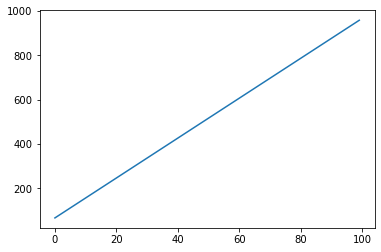

In [84]:
plt.plot([x[1] for x in ypr_r])

yaw


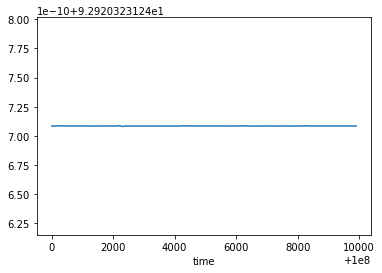

deltayaw


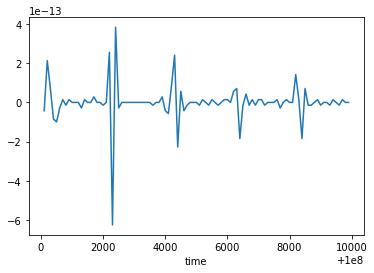

pitch


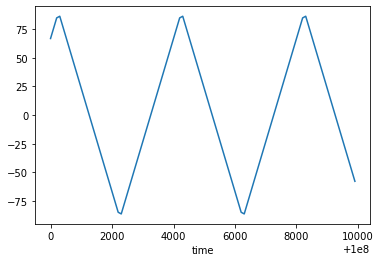

deltapitch


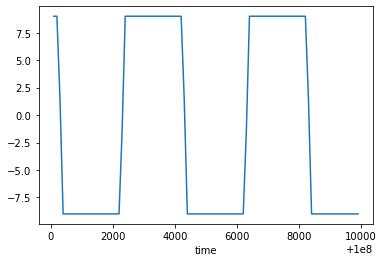

roll


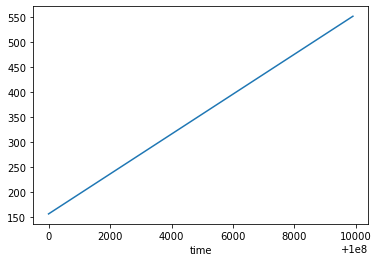

deltaroll


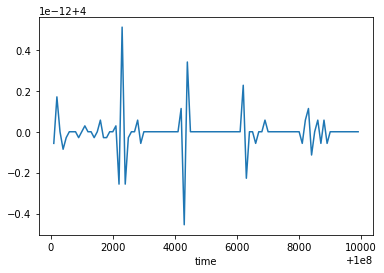

In [82]:

for col in quatcopy[['yaw','deltayaw','pitch','deltapitch','roll','deltaroll']].columns:
    print(col)
    quatcopy[col].plot()
    plt.show()

In [ ]:
def log_deviations(data, thresholds, cols):
    #data - time series (t,w,x,y,z) where t is in milliseconds, and series is regular (delta t is same across each row, can always be achieved by resampling)
    #thresholds - list of length 1 to 3 representing dA/dt, giving a rotation threshold in angles per second
    #cols - list of same length of thresholds, subset of ['y','p','r'] intending the thresholds for yaw, pitch, and roll measurements
    
    # given thresholds, we want to log the times t where the 